In [1]:
import cv2
from PIL import Image
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from dotenv import load_dotenv
import joblib
load_dotenv()

True

In [2]:
os.getcwd()

'c:\\Users\\soura\\deepedge\\white_dot_predict'

In [3]:
try:
    # Retrieve the number of images to be generated from environment variable
    num_images = int(os.getenv("num_images"))
    
    # Retrieve the filename of the CSV file from environment variable
    csv_filename = os.getenv("CSV_FILENAME")
    
    # Check if the CSV filename has the ".csv" extension
    if ".csv" not in csv_filename:
        raise Exception("INVALID_FILE_FORMAT")
    
    # Retrieve the location where the CSV file should be stored from environment variable
    location = os.getenv("LOCATION")
    
    # If location is not specified, set it to the current working directory
    if location == "":
        location = os.getcwd()
    #Retrieve model name from enviroment varaible
    model_name = os.getenv("model_name")
except Exception as e:
    if "invalid literal for int()" in str(e):
        print("Please define valid int value for the number of images to be generated in .env file.")
    else:
        print(str(e))


In [4]:
def generate_dataset(image_size=50):
    global csv_filepath,image_folder
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    x = np.random.randint(0, image_size)
    y = np.random.randint(0, image_size)
    image[y, x] = 255
    return image, x, y  # Return x,y cordinate where white spot is
num_images = num_images
csv_filename = csv_filename
location = location 
csv_filepath = os.path.join(location, csv_filename)
image_folder = os.path.join(location, 'images') 

# Check if the directory exists, if not, create it
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Open the CSV file for writing
with open(csv_filepath, 'w', newline='') as csvfile:
    # Create a CSV writer object
    File = csv.writer(csvfile)
    # Write header row
    File.writerow(["Image", "X-Coordinate", "Y-Coordinate","Img_path"])

    # Generate images and save data to CSV
    for i in range(num_images):
        image, x, y = generate_dataset()  
        image_filename = f"image_{i:05d}.png"
        image_path = os.path.join(image_folder, image_filename)
        # Save the image
        Image.fromarray(image).save(image_path)                                 
        # Write image filename , coordinates and image path to CSV
        File.writerow([image_filename, x, y, image_path])

print(f"Generated {num_images} images and saved data to {csv_filepath}")

Generated 20000 images and saved data to c:\Users\soura\deepedge\white_dot_predict\image_dataset.csv


Load the dataset

In [5]:
data= pd.read_csv(csv_filepath)
data.head()

,Image,X-Coordinate,Y-Coordinate,Img_path
0,image_00000.png,46,21,c:\Users\soura\deepedge\white_dot_predict\imag...
1,image_00001.png,45,0,c:\Users\soura\deepedge\white_dot_predict\imag...
2,image_00002.png,44,42,c:\Users\soura\deepedge\white_dot_predict\imag...
3,image_00003.png,3,17,c:\Users\soura\deepedge\white_dot_predict\imag...
4,image_00004.png,1,47,c:\Users\soura\deepedge\white_dot_predict\imag...


Data preprocessing : 
By preprocessing we get set of images represented as NumPy arrays and their corresponding labels (coordinates). 

In [6]:
def preprocess_data(data):
    images = np.array([cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in data['Img_path']])
    labels = data[['X-Coordinate', 'Y-Coordinate']].values
    return images, labels
images, labels = preprocess_data(data)

Split the data into training and validation sets

In [7]:
# Splitting data into train and test sets (80% train, 20% test)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)


#Further splitting training set into train and validation sets (75% train, 25% validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)

Define the CNN model .
As it is Regression problem , will use Linear activation function in output layer

In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)), #input layer taking (50,50) image as input 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='linear')  # Output layer with linear activation for (x, y) coordinates
])

Compile the model

In [9]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [10]:
history=model.fit(x=train_images, y=train_labels, epochs=10, validation_data=(val_images, val_labels))

Epoch 1/10
375/375 [==============================] - 20s 50ms/step - loss: 24.7124 - accuracy: 0.9626 - val_loss: 0.9949 - val_accuracy: 0.9783
Epoch 2/10
375/375 [==============================] - 19s 51ms/step - loss: 0.6931 - accuracy: 0.9811 - val_loss: 0.6897 - val_accuracy: 0.9800
Epoch 3/10
375/375 [==============================] - 19s 49ms/step - loss: 0.5569 - accuracy: 0.9806 - val_loss: 0.4840 - val_accuracy: 0.9870
Epoch 4/10
375/375 [==============================] - 19s 51ms/step - loss: 0.4680 - accuracy: 0.9864 - val_loss: 0.4259 - val_accuracy: 0.9887
Epoch 5/10
375/375 [==============================] - 19s 50ms/step - loss: 0.3131 - accuracy: 0.9868 - val_loss: 0.2815 - val_accuracy: 0.9833
Epoch 6/10
375/375 [==============================] - 19s 50ms/step - loss: 0.5390 - accuracy: 0.9876 - val_loss: 0.1241 - val_accuracy: 0.9887
Epoch 7/10
375/375 [==============================] - 19s 50ms/step - loss: 0.2777 - accuracy: 0.9902 - val_loss: 0.8289 - val_accuracy

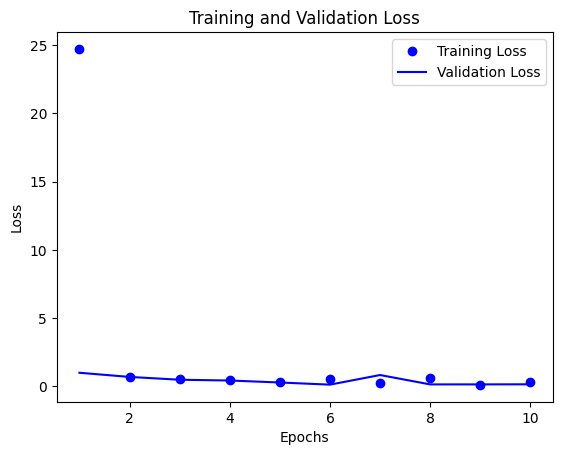

In [11]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

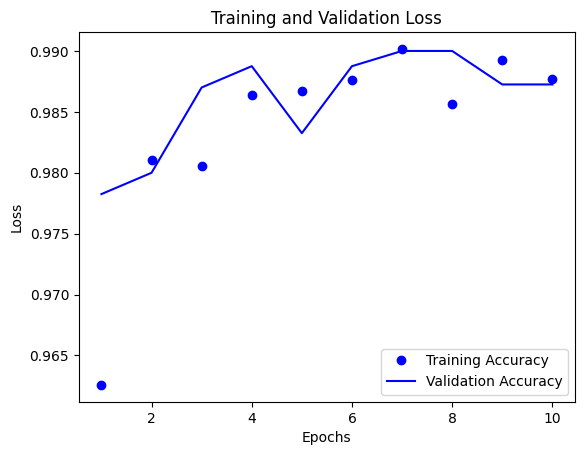

In [12]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

# Plotting
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training Accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation Accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate the model on the test set

In [13]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy}')


125/125 [==============================] - 2s 14ms/step - loss: 0.1552 - accuracy: 0.9865
Test Accuracy: 0.9865000247955322



Save the trained model

In [14]:
joblib.dump(model,model_name)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2024-04-23 15:26:35         3614
meta

['model.pkl']